In [1]:
import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import count
from pyspark.sql.functions import max, min, col

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import plotly.express as px
import altair as alt

import numpy as np
import pandas as pd

from graphframes import *
from pyspark.sql.types import *
from graphframes import *

import networkx as nx

In [2]:
# Load external packages programatically 
# Here, we assume that you use Spark 3.0.1 or later (compiled against Scala 2.12)
import os
packages = "graphframes:graphframes:0.8.1-spark3.0-s_2.12"
# jars = "graphframes-0.3.0-spark2.0-s_2.11.jar"

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--repositories https://repos.spark-packages.org/ --packages {0} pyspark-shell".format(packages)
)
#os.environ["PYSPARK_SUBMIT_ARGS"] = (
#    "--packages {0} --jars {1} pyspark-shell".format(packages, jars)
#)

In [3]:
spark = (SparkSession     
         .builder     
         .appName("IMDb")     
         .getOrCreate())

In [4]:
movies = pd.read_csv('../data/IMDb_movies.csv')

/home/lydia/miniconda3/envs/TGFLYDIA/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
movies.head()

imdb_title_id                        title               original_title  \
0     tt0000009                   Miss Jerry                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm               Den sorte drøm   
3     tt0002101                    Cleopatra                    Cleopatra   
4     tt0002130                    L'Inferno                    L'Inferno   

   year date_published                      genre  duration           country  \
0  1894     1894-10-09                    Romance        45               USA   
1  1906     1906-12-26    Biography, Crime, Drama        70         Australia   
2  1911     1911-08-19                      Drama        53  Germany, Denmark   
3  1912     1912-11-13             Drama, History       100               USA   
4  1911     1911-03-06  Adventure, Drama, Fantasy        68             Italy   

  language                             director  ...  \
0     None                      Alexander Black  ...   
1     None                         Charles Tait  ...   
2      NaN                            Urban Gad  ...   
3  English                   Charles L. Gaskill  ...   
4  Italian  Francesco Bertolini, Adolfo Padovan  ...   

                                              actors  \
0  Blanche Bayliss, William Courtenay, Chauncey D...   
1  Elizabeth Tait, John Tait, Norman Campbell, Be...   
2  Asta Nielsen, Valdemar Psilander, Gunnar Helse...   
3  Helen Gardner, Pearl Sindelar, Miss Fielding, ...   
4  Salvatore Papa, Arturo Pirovano, Giuseppe de L...   

                                         description avg_vote votes   budget  \
0  The adventures of a female reporter in the 1890s.      5.9   154      NaN   
1  True story of notorious Australian outlaw Ned ...      6.1   589   $ 2250   
2  Two men of high rank are both wooing the beaut...      5.8   188      NaN   
3  The fabled queen of Egypt's affair with Roman ...      5.2   446  $ 45000   
4  Loosely adapted from Dante's Divine Comedy and...      7.0  2237      NaN   

   usa_gross_income worlwide_gross_income metascore reviews_from_users  \
0               NaN                   NaN       NaN                1.0   
1               NaN                   NaN       NaN                7.0   
2               NaN                   NaN       NaN                5.0   
3               NaN                   NaN       NaN               25.0   
4               NaN                   NaN       NaN               31.0   

   reviews_from_critics  
0                   2.0  
1                   7.0  
2                   2.0  
3                   3.0  
4                  14.0  

[5 rows x 22 columns]

In [6]:
print('\nColumns with missing value:') 
print(movies.isnull().any())


Columns with missing value:
imdb_title_id            False
title                    False
original_title           False
year                     False
date_published           False
genre                    False
duration                 False
country                   True
language                  True
director                  True
writer                    True
production_company        True
actors                    True
description               True
avg_vote                 False
votes                    False
budget                    True
usa_gross_income          True
worlwide_gross_income     True
metascore                 True
reviews_from_users        True
reviews_from_critics      True
dtype: bool


In [7]:
movies.isnull().sum().sum()

288652

In [8]:
movies.country.fillna("Country Unavailable", inplace=True)
movies.language.fillna("Language Unavailable", inplace=True)
movies.director.fillna("No director", inplace=True)
movies.writer.fillna("No writer", inplace=True)
movies.production_company.fillna("No production company", inplace=True)
movies.actors.fillna("No actors", inplace=True)
movies.description.fillna("Description Unavailable", inplace=True)
movies.budget.fillna("Budget Unavailable", inplace=True)
movies.usa_gross_income.fillna("Usa Gross Income Unavailable", inplace=True)
movies.worlwide_gross_income.fillna("Worlwid Gross Income Unavailable", inplace=True)
movies.metascore.fillna("Metascore Unavailable", inplace=True)
#df.reviews_from_users.fillna("Reviews From Users Unavailable", inplace=True)
#df.reviews_from_critics.fillna("Reviews From Critics Unavailable", inplace=True)

In [9]:
movies['list_directors'] = movies['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['list_categories'] = movies['genre'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['list_actors'] = movies['actors'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['list_countries'] = movies['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['reviews_from_users'] = pd.to_numeric(movies['reviews_from_users'], downcast="integer")
movies['reviews_from_critics'] = pd.to_numeric(movies['reviews_from_critics'], downcast="integer")

In [10]:
movies.head()

imdb_title_id                        title               original_title  \
0     tt0000009                   Miss Jerry                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm               Den sorte drøm   
3     tt0002101                    Cleopatra                    Cleopatra   
4     tt0002130                    L'Inferno                    L'Inferno   

   year date_published                      genre  duration           country  \
0  1894     1894-10-09                    Romance        45               USA   
1  1906     1906-12-26    Biography, Crime, Drama        70         Australia   
2  1911     1911-08-19                      Drama        53  Germany, Denmark   
3  1912     1912-11-13             Drama, History       100               USA   
4  1911     1911-03-06  Adventure, Drama, Fantasy        68             Italy   

               language                             director  ...  \
0                  None                      Alexander Black  ...   
1                  None                         Charles Tait  ...   
2  Language Unavailable                            Urban Gad  ...   
3               English                   Charles L. Gaskill  ...   
4               Italian  Francesco Bertolini, Adolfo Padovan  ...   

               budget              usa_gross_income  \
0  Budget Unavailable  Usa Gross Income Unavailable   
1              $ 2250  Usa Gross Income Unavailable   
2  Budget Unavailable  Usa Gross Income Unavailable   
3             $ 45000  Usa Gross Income Unavailable   
4  Budget Unavailable  Usa Gross Income Unavailable   

              worlwide_gross_income              metascore  \
0  Worlwid Gross Income Unavailable  Metascore Unavailable   
1  Worlwid Gross Income Unavailable  Metascore Unavailable   
2  Worlwid Gross Income Unavailable  Metascore Unavailable   
3  Worlwid Gross Income Unavailable  Metascore Unavailable   
4  Worlwid Gross Income Unavailable  Metascore Unavailable   

   reviews_from_users  reviews_from_critics  \
0                 1.0                   2.0   
1                 7.0                   7.0   
2                 5.0                   2.0   
3                25.0                   3.0   
4                31.0                  14.0   

                          list_directors              list_categories  \
0                      [Alexander Black]                    [Romance]   
1                         [Charles Tait]    [Biography, Crime, Drama]   
2                            [Urban Gad]                      [Drama]   
3                   [Charles L. Gaskill]             [Drama, History]   
4  [Francesco Bertolini, Adolfo Padovan]  [Adventure, Drama, Fantasy]   

                                         list_actors      list_countries  
0  [Blanche Bayliss, William Courtenay, Chauncey ...               [USA]  
1  [Elizabeth Tait, John Tait, Norman Campbell, B...         [Australia]  
2  [Asta Nielsen, Valdemar Psilander, Gunnar Hels...  [Germany, Denmark]  
3  [Helen Gardner, Pearl Sindelar, Miss Fielding,...               [USA]  
4  [Salvatore Papa, Arturo Pirovano, Giuseppe de ...             [Italy]  

[5 rows x 26 columns]

In [11]:
actor = "Leonardo DiCaprio"
G_actor = nx.Graph()
for i, rowi in movies.iterrows():
    for j in rowi['list_actors']:
        if j==actor and (rowi['avg_vote'] >= 8.5 or rowi['avg_vote'] < 5.0):
            print (rowi['title'])
            print (rowi['avg_vote'])
            G_actor.add_node(rowi['title'],key=rowi['imdb_title_id'],rating_users=rowi['reviews_from_users'], rating_critics=rowi['reviews_from_critics'],avg_vote=rowi["avg_vote"],label="MOVIE")
            for element in rowi['list_actors']:
                G_actor.add_node(element, label="PERSON")
                G_actor.add_edge(rowi['title'], element, label="ACTED_IN")

Critters 3
4.4
The Departed - Il bene e il male
8.5
Inception
8.8


In [12]:
def show_graph_Leonardo(G):

    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#F9E79F',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }
    
    colors=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('#72bbd0')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('#eebcbc')
    sizes=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="MOVIE":
            size=G.nodes[e]['avg_vote']*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="PERSON" and e == "Leonardo DiCaprio":
            sizes.append(8000)
        else:
            sizes.append(1000)
        
        
    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.80, iterations=50), **options)
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555") 
    plt.show()

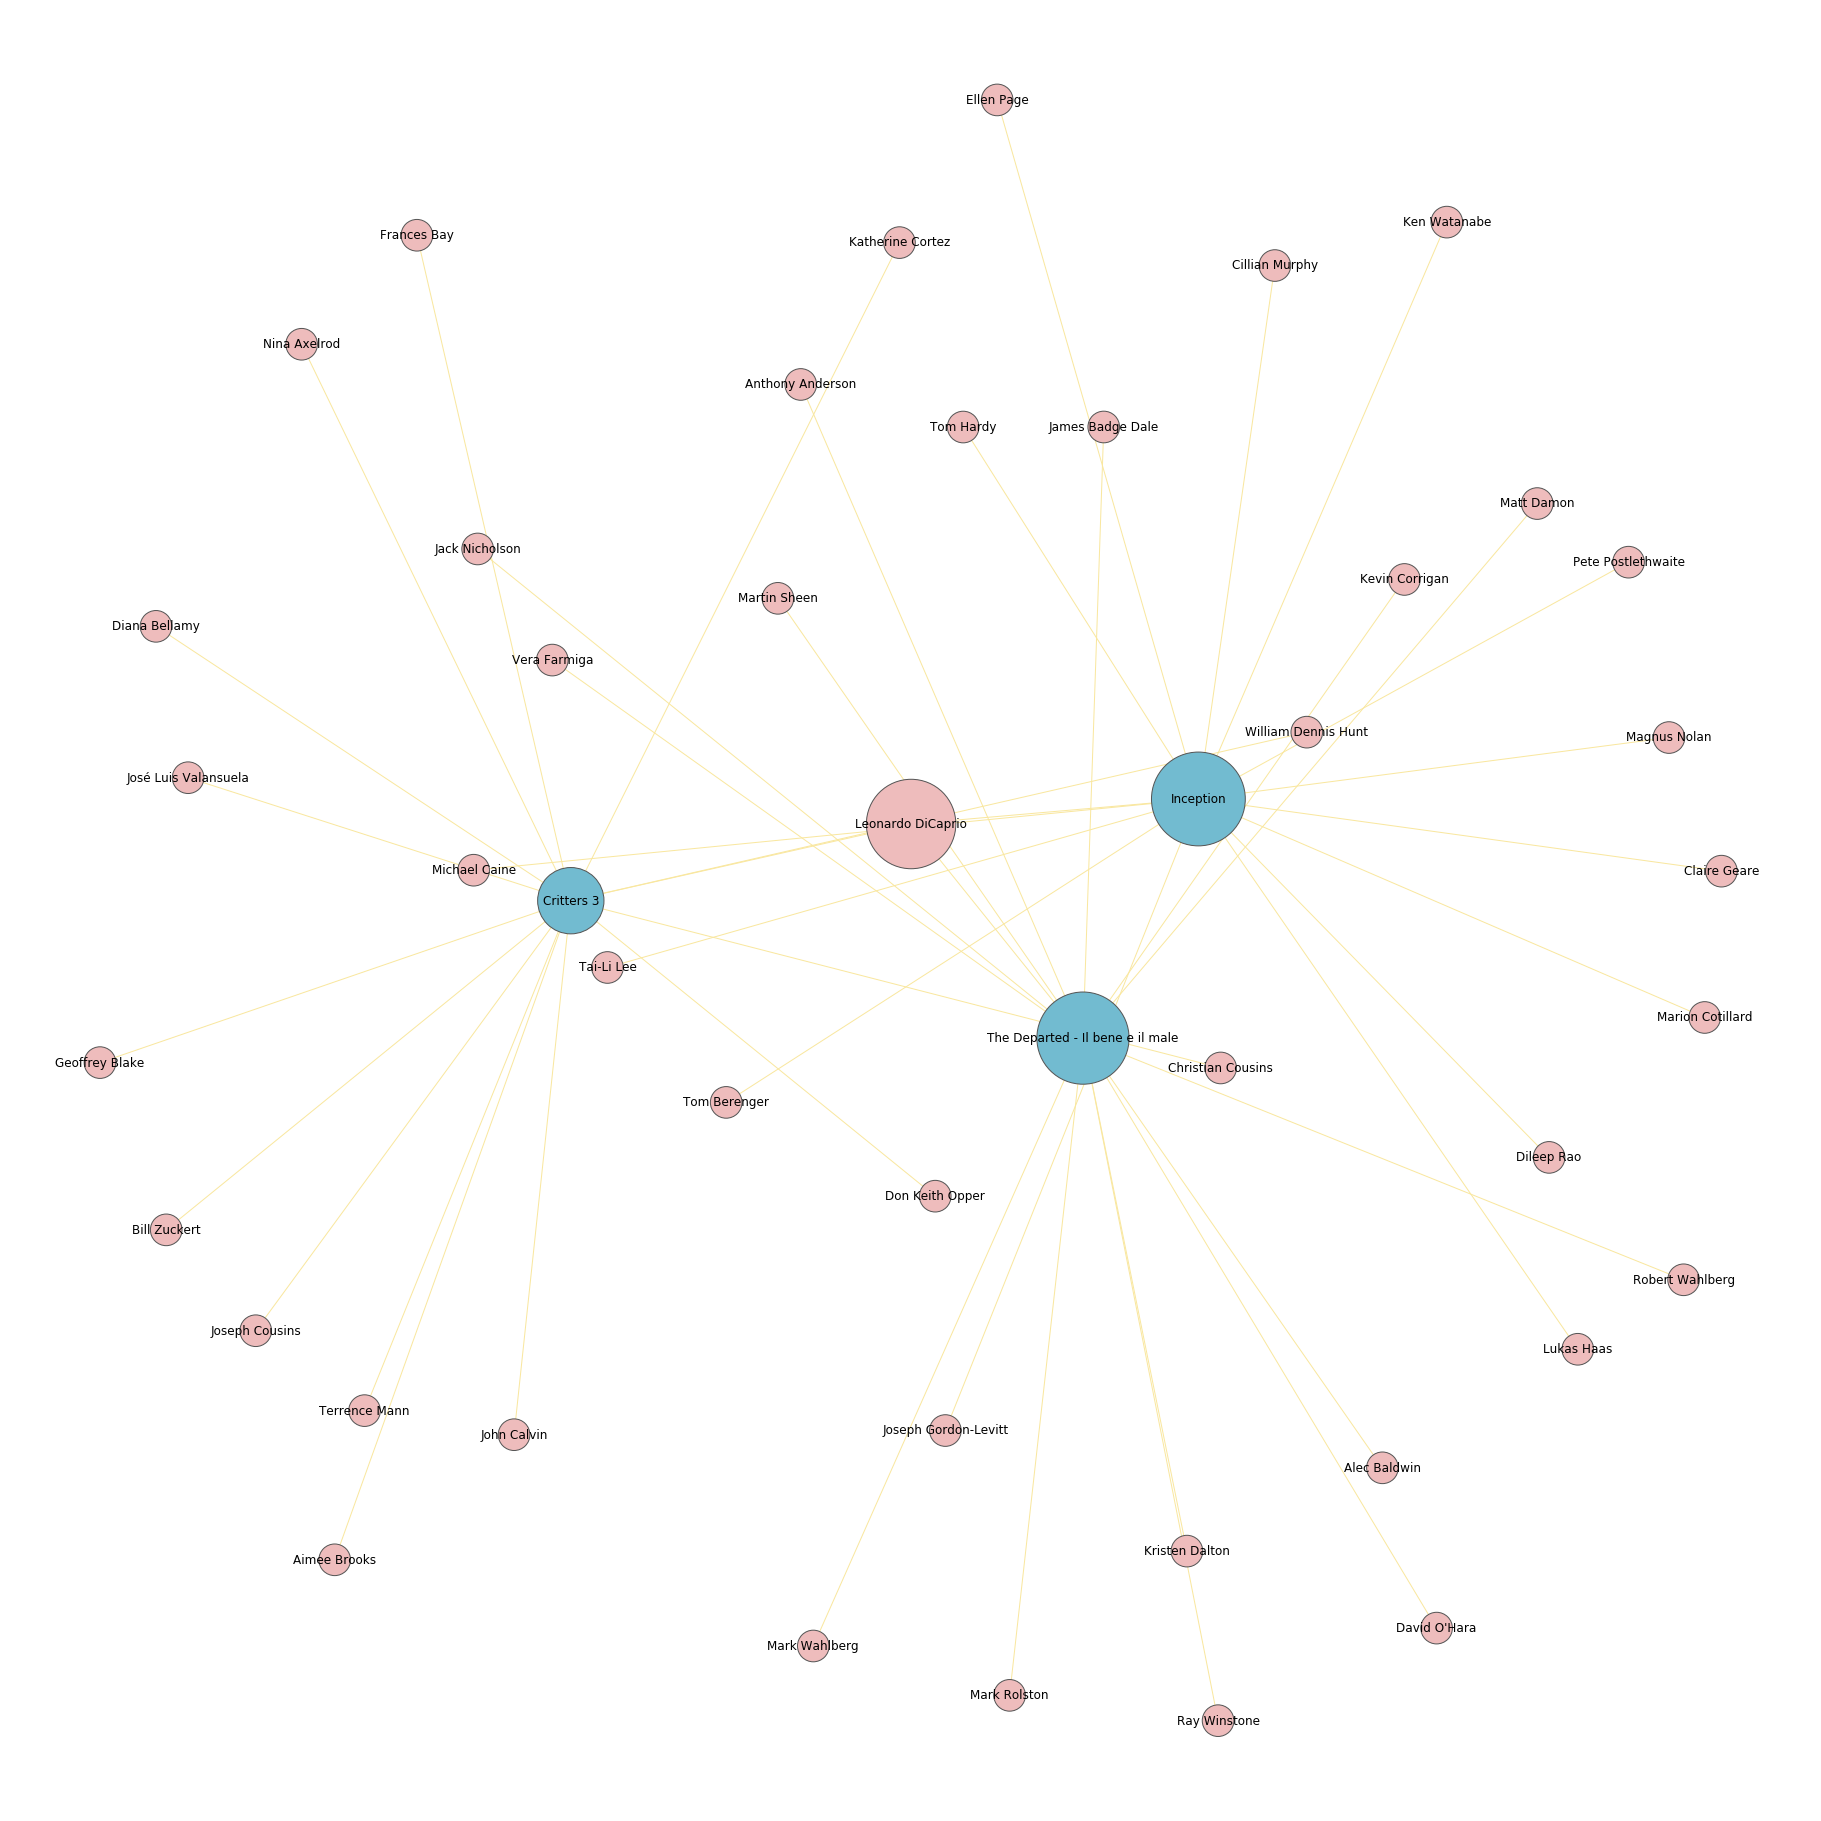

In [13]:
show_graph_Leonardo(G_actor)

In [14]:
degree_centrality_actor = nx.degree_centrality(G_actor)
sorted_degree_centrality_actor = sorted(degree_centrality_actor.items(),key=lambda x:x[1],reverse=True)
sorted_degree_centrality_actor

[('Critters 3', 0.33333333333333337),
 ('The Departed - Il bene e il male', 0.33333333333333337),
 ('Inception', 0.33333333333333337),
 ('Leonardo DiCaprio', 0.06666666666666667),
 ('John Calvin', 0.022222222222222223),
 ('Aimee Brooks', 0.022222222222222223),
 ('Christian Cousins', 0.022222222222222223),
 ('Joseph Cousins', 0.022222222222222223),
 ('William Dennis Hunt', 0.022222222222222223),
 ('Nina Axelrod', 0.022222222222222223),
 ('Don Keith Opper', 0.022222222222222223),
 ('Geoffrey Blake', 0.022222222222222223),
 ('José Luis Valansuela', 0.022222222222222223),
 ('Diana Bellamy', 0.022222222222222223),
 ('Katherine Cortez', 0.022222222222222223),
 ('Frances Bay', 0.022222222222222223),
 ('Bill Zuckert', 0.022222222222222223),
 ('Terrence Mann', 0.022222222222222223),
 ('Matt Damon', 0.022222222222222223),
 ('Jack Nicholson', 0.022222222222222223),
 ('Mark Wahlberg', 0.022222222222222223),
 ('Martin Sheen', 0.022222222222222223),
 ('Ray Winstone', 0.022222222222222223),
 ('Vera F

In [15]:
betweenness_centrality_actor = nx.betweenness_centrality(G_actor)
sorted_betweenness_centrality_actor = sorted(betweenness_centrality_actor.items(),key=lambda x:x[1],reverse=True)
sorted_betweenness_centrality_actor

[('Leonardo DiCaprio', 0.6818181818181818),
 ('Critters 3', 0.5303030303030303),
 ('The Departed - Il bene e il male', 0.5303030303030303),
 ('Inception', 0.5303030303030303),
 ('John Calvin', 0.0),
 ('Aimee Brooks', 0.0),
 ('Christian Cousins', 0.0),
 ('Joseph Cousins', 0.0),
 ('William Dennis Hunt', 0.0),
 ('Nina Axelrod', 0.0),
 ('Don Keith Opper', 0.0),
 ('Geoffrey Blake', 0.0),
 ('José Luis Valansuela', 0.0),
 ('Diana Bellamy', 0.0),
 ('Katherine Cortez', 0.0),
 ('Frances Bay', 0.0),
 ('Bill Zuckert', 0.0),
 ('Terrence Mann', 0.0),
 ('Matt Damon', 0.0),
 ('Jack Nicholson', 0.0),
 ('Mark Wahlberg', 0.0),
 ('Martin Sheen', 0.0),
 ('Ray Winstone', 0.0),
 ('Vera Farmiga', 0.0),
 ('Anthony Anderson', 0.0),
 ('Alec Baldwin', 0.0),
 ('Kevin Corrigan', 0.0),
 ('James Badge Dale', 0.0),
 ("David O'Hara", 0.0),
 ('Mark Rolston', 0.0),
 ('Robert Wahlberg', 0.0),
 ('Kristen Dalton', 0.0),
 ('Joseph Gordon-Levitt', 0.0),
 ('Ellen Page', 0.0),
 ('Tom Hardy', 0.0),
 ('Ken Watanabe', 0.0),
 ('Dil

In [16]:
closeness_centrality_actor = nx.closeness_centrality(G_actor)
sorted_closeness_centrality_actor = sorted(closeness_centrality_actor.items(),key=lambda x:x[1],reverse=True)

sorted_closeness_centrality_actor

[('Leonardo DiCaprio', 0.5172413793103449),
 ('Critters 3', 0.4368932038834951),
 ('The Departed - Il bene e il male', 0.4368932038834951),
 ('Inception', 0.4368932038834951),
 ('John Calvin', 0.30612244897959184),
 ('Aimee Brooks', 0.30612244897959184),
 ('Christian Cousins', 0.30612244897959184),
 ('Joseph Cousins', 0.30612244897959184),
 ('William Dennis Hunt', 0.30612244897959184),
 ('Nina Axelrod', 0.30612244897959184),
 ('Don Keith Opper', 0.30612244897959184),
 ('Geoffrey Blake', 0.30612244897959184),
 ('José Luis Valansuela', 0.30612244897959184),
 ('Diana Bellamy', 0.30612244897959184),
 ('Katherine Cortez', 0.30612244897959184),
 ('Frances Bay', 0.30612244897959184),
 ('Bill Zuckert', 0.30612244897959184),
 ('Terrence Mann', 0.30612244897959184),
 ('Matt Damon', 0.30612244897959184),
 ('Jack Nicholson', 0.30612244897959184),
 ('Mark Wahlberg', 0.30612244897959184),
 ('Martin Sheen', 0.30612244897959184),
 ('Ray Winstone', 0.30612244897959184),
 ('Vera Farmiga', 0.306122448979

In [17]:
eigenvector_centrality_actor = nx.eigenvector_centrality(G_actor)
sorted_eigenvector_centrality_actor = sorted(eigenvector_centrality_actor.items(),key=lambda x:x[1],reverse=True)

sorted_eigenvector_centrality_actor

[('Critters 3', 0.4082492726739824),
 ('The Departed - Il bene e il male', 0.4082492726739824),
 ('Inception', 0.4082492726739824),
 ('Leonardo DiCaprio', 0.2970435482284468),
 ('John Calvin', 0.09901451607614893),
 ('Aimee Brooks', 0.09901451607614893),
 ('Christian Cousins', 0.09901451607614893),
 ('Joseph Cousins', 0.09901451607614893),
 ('William Dennis Hunt', 0.09901451607614893),
 ('Nina Axelrod', 0.09901451607614893),
 ('Don Keith Opper', 0.09901451607614893),
 ('Geoffrey Blake', 0.09901451607614893),
 ('José Luis Valansuela', 0.09901451607614893),
 ('Diana Bellamy', 0.09901451607614893),
 ('Katherine Cortez', 0.09901451607614893),
 ('Frances Bay', 0.09901451607614893),
 ('Bill Zuckert', 0.09901451607614893),
 ('Terrence Mann', 0.09901451607614893),
 ('Matt Damon', 0.09901451607614893),
 ('Jack Nicholson', 0.09901451607614893),
 ('Mark Wahlberg', 0.09901451607614893),
 ('Martin Sheen', 0.09901451607614893),
 ('Ray Winstone', 0.09901451607614893),
 ('Vera Farmiga', 0.099014516076

In [18]:
degree_actor = nx.degree(G_actor)
degree_actor = sorted(degree_actor,key=lambda x:x[1],reverse=True)

degree_actor

[('Critters 3', 15),
 ('The Departed - Il bene e il male', 15),
 ('Inception', 15),
 ('Leonardo DiCaprio', 3),
 ('John Calvin', 1),
 ('Aimee Brooks', 1),
 ('Christian Cousins', 1),
 ('Joseph Cousins', 1),
 ('William Dennis Hunt', 1),
 ('Nina Axelrod', 1),
 ('Don Keith Opper', 1),
 ('Geoffrey Blake', 1),
 ('José Luis Valansuela', 1),
 ('Diana Bellamy', 1),
 ('Katherine Cortez', 1),
 ('Frances Bay', 1),
 ('Bill Zuckert', 1),
 ('Terrence Mann', 1),
 ('Matt Damon', 1),
 ('Jack Nicholson', 1),
 ('Mark Wahlberg', 1),
 ('Martin Sheen', 1),
 ('Ray Winstone', 1),
 ('Vera Farmiga', 1),
 ('Anthony Anderson', 1),
 ('Alec Baldwin', 1),
 ('Kevin Corrigan', 1),
 ('James Badge Dale', 1),
 ("David O'Hara", 1),
 ('Mark Rolston', 1),
 ('Robert Wahlberg', 1),
 ('Kristen Dalton', 1),
 ('Joseph Gordon-Levitt', 1),
 ('Ellen Page', 1),
 ('Tom Hardy', 1),
 ('Ken Watanabe', 1),
 ('Dileep Rao', 1),
 ('Cillian Murphy', 1),
 ('Tom Berenger', 1),
 ('Marion Cotillard', 1),
 ('Pete Postlethwaite', 1),
 ('Michael Cain

In [19]:
director = "Tim Burton"
num_jhonny_deep = 0
num_helena_bonham = 0
num_michael_gough = 0
num_danny_devito = 0
G_director = nx.Graph()
for i, rowi in movies.iterrows():
    for element in rowi['list_directors']:
        if (element==director):
            print (rowi['title'])
            G_director.add_node(element,label="DIRECTOR")
            G_director.add_node(rowi['title'],key=rowi['imdb_title_id'],label="MOVIE")
            G_director.add_edge(rowi['title'], element, label="DIRECTED")
            for actor in rowi['list_actors']:
                if actor == "Johnny Depp":
                    num_jhonny_deep = num_jhonny_deep + 1
                    G_director.add_node(actor,label="JHONNY")
                    G_director.add_edge(element, actor, label="DIRECTED BY")
                    G_director.add_edge(rowi['title'], actor, label="ACTED_IN")
                elif actor == "Helena Bonham Carter":
                    num_helena_bonham = num_helena_bonham + 1
                    G_director.add_node(actor,label="HELENA")
                    G_director.add_edge(element, actor, label="DIRECTED BY")
                    G_director.add_edge(rowi['title'], actor, label="ACTED_IN")
                elif actor == "Michael Gough":
                    G_director.add_node(actor,label="MICHAEL")
                    G_director.add_edge(element, actor, label="DIRECTED BY")
                    G_director.add_edge(rowi['title'], actor, label="ACTED_IN")
                    num_michael_gough = num_michael_gough + 1
                elif actor == "Danny DeVito":
                    G_director.add_node(actor,label="DANNY")
                    G_director.add_edge(element, actor, label="DIRECTED BY")
                    G_director.add_edge(rowi['title'], actor, label="ACTED_IN")
                    num_danny_devito = num_danny_devito + 1
                    
print(num_jhonny_deep)
print(num_helena_bonham)
print(num_michael_gough)
print(num_danny_devito)

Pee-wee's Big Adventure
Beetlejuice - Spiritello porcello
Batman
Edward mani di forbice
Batman - Il ritorno
Ed Wood
Mars Attacks!
La sposa cadavere
Planet of the Apes - Il pianeta delle scimmie
Il mistero di Sleepy Hollow
Big Fish - Le storie di una vita incredibile
La fabbrica di cioccolato
Sweeney Todd - Il diabolico barbiere di Fleet Street
Alice in Wonderland
Dark Shadows
Big Eyes
Frankenweenie
Miss Peregrine - La casa dei ragazzi speciali
Dumbo
8
7
4
3


In [20]:
def show_graph_director(G, num_jhonny, num_helena, num_michael, num_danny):

    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#F9E79F',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }
    colors=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="JHONNY":
            colors.append('#72bbd0')
        elif G.nodes[e]['label']=="HELENA":
            colors.append('#91f0a1')
        elif G.nodes[e]['label']=="MICHAEL":
            colors.append('#ffdf55')
        elif G.nodes[e]['label']=="DANNY":
            colors.append('#eebcbc')
        elif G.nodes[e]['label']=="DIRECTOR":
            colors.append('#A554E4')
        elif G.nodes[e]['label']=="MOVIE":
            colors.append('#40D3CA')
    sizes=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="JHONNY":
            size=num_jhonny*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="HELENA":
            size=num_helena*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="MICHAEL":
            size=num_michael*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="DANNY":
            size=num_danny*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="DIRECTOR":
            sizes.append(8000)
        else:
            sizes.append(1000)
    print(sizes)
    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.80, iterations=50), **options)
    plt.show()

[8000, 1000, 1000, 1000, 4000, 1000, 8000, 1000, 3000, 1000, 1000, 1000, 7000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


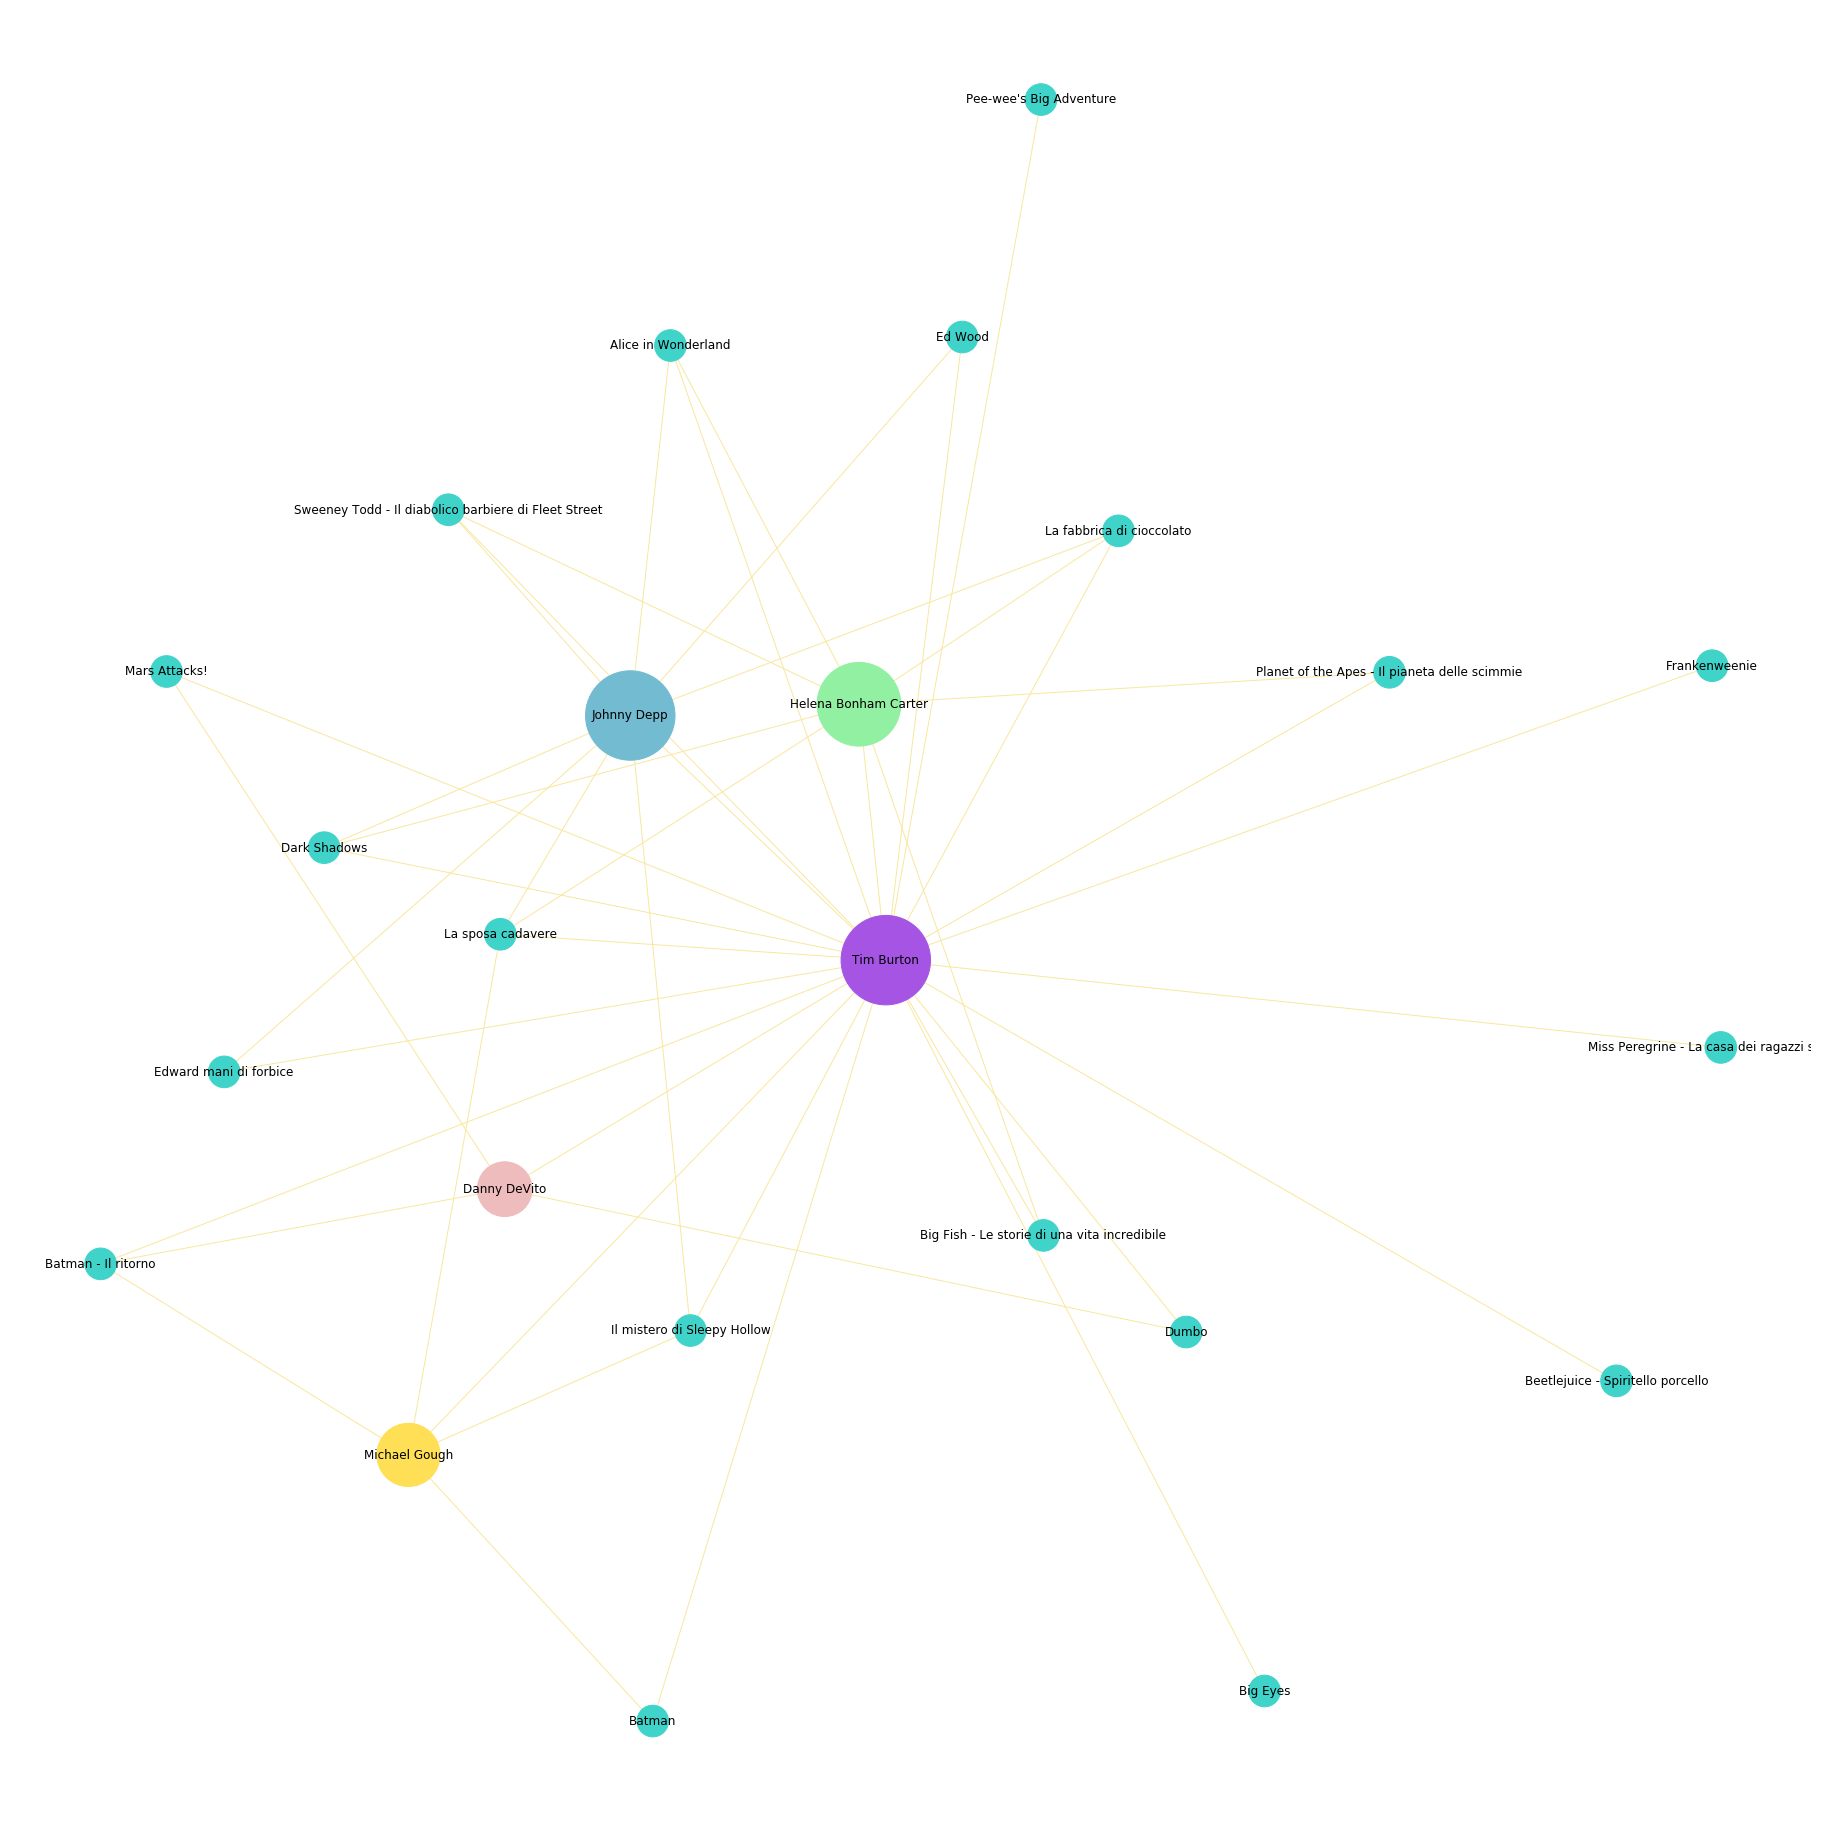

In [21]:
show_graph_director(G_director, num_jhonny_deep, num_helena_bonham, num_michael_gough, num_danny_devito)

In [22]:
degree_centrality_director = nx.degree_centrality(G_director)
sorted_degree_centrality_director = sorted(degree_centrality_director.items(),key=lambda x:x[1],reverse=True)
sorted_degree_centrality_director

[('Tim Burton', 1.0),
 ('Johnny Depp', 0.3913043478260869),
 ('Helena Bonham Carter', 0.34782608695652173),
 ('Michael Gough', 0.21739130434782608),
 ('Danny DeVito', 0.17391304347826086),
 ('La sposa cadavere', 0.17391304347826086),
 ('Batman - Il ritorno', 0.13043478260869565),
 ('Il mistero di Sleepy Hollow', 0.13043478260869565),
 ('La fabbrica di cioccolato', 0.13043478260869565),
 ('Sweeney Todd - Il diabolico barbiere di Fleet Street', 0.13043478260869565),
 ('Alice in Wonderland', 0.13043478260869565),
 ('Dark Shadows', 0.13043478260869565),
 ('Batman', 0.08695652173913043),
 ('Edward mani di forbice', 0.08695652173913043),
 ('Ed Wood', 0.08695652173913043),
 ('Mars Attacks!', 0.08695652173913043),
 ('Planet of the Apes - Il pianeta delle scimmie', 0.08695652173913043),
 ('Big Fish - Le storie di una vita incredibile', 0.08695652173913043),
 ('Dumbo', 0.08695652173913043),
 ("Pee-wee's Big Adventure", 0.043478260869565216),
 ('Beetlejuice - Spiritello porcello', 0.0434782608695

In [23]:
betweenness_centrality_director = nx.betweenness_centrality(G_director)
sorted_betweenness_centrality_director = sorted(betweenness_centrality_director.items(),key=lambda x:x[1],reverse=True)
sorted_betweenness_centrality_director

[('Tim Burton', 0.8030303030303029),
 ('Johnny Depp', 0.048089591567852426),
 ('Helena Bonham Carter', 0.03491436100131752),
 ('Michael Gough', 0.011198945981554674),
 ('Danny DeVito', 0.005928853754940711),
 ('La sposa cadavere', 0.003952569169960474),
 ('Batman - Il ritorno', 0.001976284584980237),
 ('Il mistero di Sleepy Hollow', 0.0013175230566534913),
 ('La fabbrica di cioccolato', 0.0006587615283267456),
 ('Sweeney Todd - Il diabolico barbiere di Fleet Street',
  0.0006587615283267456),
 ('Alice in Wonderland', 0.0006587615283267456),
 ('Dark Shadows', 0.0006587615283267456),
 ("Pee-wee's Big Adventure", 0.0),
 ('Beetlejuice - Spiritello porcello', 0.0),
 ('Batman', 0.0),
 ('Edward mani di forbice', 0.0),
 ('Ed Wood', 0.0),
 ('Mars Attacks!', 0.0),
 ('Planet of the Apes - Il pianeta delle scimmie', 0.0),
 ('Big Fish - Le storie di una vita incredibile', 0.0),
 ('Big Eyes', 0.0),
 ('Frankenweenie', 0.0),
 ('Miss Peregrine - La casa dei ragazzi speciali', 0.0),
 ('Dumbo', 0.0)]

In [24]:
closeness_centrality_director = nx.closeness_centrality(G_director)
sorted_closeness_centrality_director = sorted(closeness_centrality_director.items(),key=lambda x:x[1],reverse=True)

sorted_closeness_centrality_director

[('Tim Burton', 1.0),
 ('Johnny Depp', 0.6216216216216216),
 ('Helena Bonham Carter', 0.6052631578947368),
 ('Michael Gough', 0.5609756097560976),
 ('Danny DeVito', 0.5476190476190477),
 ('La sposa cadavere', 0.5476190476190477),
 ('Batman - Il ritorno', 0.5348837209302325),
 ('Il mistero di Sleepy Hollow', 0.5348837209302325),
 ('La fabbrica di cioccolato', 0.5348837209302325),
 ('Sweeney Todd - Il diabolico barbiere di Fleet Street', 0.5348837209302325),
 ('Alice in Wonderland', 0.5348837209302325),
 ('Dark Shadows', 0.5348837209302325),
 ('Batman', 0.5227272727272727),
 ('Edward mani di forbice', 0.5227272727272727),
 ('Ed Wood', 0.5227272727272727),
 ('Mars Attacks!', 0.5227272727272727),
 ('Planet of the Apes - Il pianeta delle scimmie', 0.5227272727272727),
 ('Big Fish - Le storie di una vita incredibile', 0.5227272727272727),
 ('Dumbo', 0.5227272727272727),
 ("Pee-wee's Big Adventure", 0.5111111111111111),
 ('Beetlejuice - Spiritello porcello', 0.5111111111111111),
 ('Big Eyes',

In [25]:
eigenvector_centrality_director = nx.eigenvector_centrality(G_director)
sorted_eigenvector_centrality_director = sorted(eigenvector_centrality_director.items(),key=lambda x:x[1],reverse=True)

sorted_eigenvector_centrality_director

[('Tim Burton', 0.5807610443236201),
 ('Johnny Depp', 0.3217354926889354),
 ('Helena Bonham Carter', 0.2924318797225994),
 ('La sposa cadavere', 0.22151578134272398),
 ('Michael Gough', 0.19860355466811452),
 ('La fabbrica di cioccolato', 0.1899458324421759),
 ('Sweeney Todd - Il diabolico barbiere di Fleet Street', 0.1899458324421759),
 ('Alice in Wonderland', 0.1899458324421759),
 ('Dark Shadows', 0.1899458324421759),
 ('Il mistero di Sleepy Hollow', 0.17503085425794393),
 ('Danny DeVito', 0.1529551120251212),
 ('Batman - Il ritorno', 0.1482014728131225),
 ('Edward mani di forbice', 0.14346090535739578),
 ('Ed Wood', 0.14346090535739578),
 ('Planet of the Apes - Il pianeta delle scimmie', 0.1388027895618023),
 ('Big Fish - Le storie di una vita incredibile', 0.1388027895618023),
 ('Batman', 0.12388781137757035),
 ('Mars Attacks!', 0.11663152391257438),
 ('Dumbo', 0.11663152391257438),
 ("Pee-wee's Big Adventure", 0.0923178624770222),
 ('Beetlejuice - Spiritello porcello', 0.092317862

In [26]:
degree_director = nx.degree(G_director)
degree_director = sorted(degree_director,key=lambda x:x[1],reverse=True)

degree_director

[('Tim Burton', 23),
 ('Johnny Depp', 9),
 ('Helena Bonham Carter', 8),
 ('Michael Gough', 5),
 ('Danny DeVito', 4),
 ('La sposa cadavere', 4),
 ('Batman - Il ritorno', 3),
 ('Il mistero di Sleepy Hollow', 3),
 ('La fabbrica di cioccolato', 3),
 ('Sweeney Todd - Il diabolico barbiere di Fleet Street', 3),
 ('Alice in Wonderland', 3),
 ('Dark Shadows', 3),
 ('Batman', 2),
 ('Edward mani di forbice', 2),
 ('Ed Wood', 2),
 ('Mars Attacks!', 2),
 ('Planet of the Apes - Il pianeta delle scimmie', 2),
 ('Big Fish - Le storie di una vita incredibile', 2),
 ('Dumbo', 2),
 ("Pee-wee's Big Adventure", 1),
 ('Beetlejuice - Spiritello porcello', 1),
 ('Big Eyes', 1),
 ('Frankenweenie', 1),
 ('Miss Peregrine - La casa dei ragazzi speciali', 1)]

In [27]:
actor = "Chris Hemsworth"
num_natalie_portman = 0
num_robert_downey_jr = 0
num_tessa_thompson = 0
num_kristen_stewart = 0
num_tom_hiddleston = 0
G_actor_with_others = nx.Graph()
for i, rowi in movies.iterrows():
    for element in rowi['list_actors']:
        if (element==actor):
            print(rowi['title'])
            G_actor_with_others.add_node(element,label="PERSON")
            G_actor_with_others.add_node(rowi['title'],key=rowi['imdb_title_id'],label="MOVIE")
            G_actor_with_others.add_edge(rowi['title'], element, label="ACTED_IN")
            for person in rowi['list_actors']:
                if person == "Natalie Portman":
                    num_natalie_portman = num_natalie_portman + 1
                    G_actor_with_others.add_node(person,label="NATALIE")
                    G_actor_with_others.add_edge(rowi['title'], person, label="ACTED_IN")
                elif person == "Robert Downey Jr.":
                    num_robert_downey_jr = num_robert_downey_jr + 1
                    G_actor_with_others.add_node(person,label="ROBERT")
                    G_actor_with_others.add_edge(rowi['title'], person, label="ACTED_IN")
                elif person == "Tessa Thompson":
                    num_tessa_thompson = num_tessa_thompson + 1
                    G_actor_with_others.add_node(person,label="TESSA")
                    G_actor_with_others.add_edge(rowi['title'], person, label="ACTED_IN")
                elif person == "Kristen Stewart":
                    num_kristen_stewart = num_kristen_stewart + 1
                    G_actor_with_others.add_node(person,label="KRISTEN")
                    G_actor_with_others.add_edge(rowi['title'], person, label="ACTED_IN")
                elif person == "Tom Hiddleston":
                    num_tom_hiddleston = num_tom_hiddleston + 1
                    G_actor_with_others.add_node(person,label="TOM")
                    G_actor_with_others.add_edge(rowi['title'], person, label="ACTED_IN")
                
print(num_natalie_portman)
print(num_robert_downey_jr)
print(num_tessa_thompson)
print(num_kristen_stewart)
print(num_tom_hiddleston)

Star Trek
Thor
The Avengers
A Perfect Getaway - Una perfetta via di fuga
Cash Game - Paga o muori
Red Dawn - Alba rossa
Quella casa nel bosco
Heart of the Sea - Le origini di Moby Dick
12 Soldiers
Come ti rovino le vacanze
Biancaneve e il cacciatore
Rush
Thor: The Dark World
Men in Black: International
Il cacciatore e la regina di ghiaccio
Avengers: Age of Ultron
Blackhat
Thor: Ragnarok
Avengers: Infinity War
Avengers: Endgame
7 sconosciuti a El Royale
Tyler Rake
2
4
2
1
5


In [28]:
def show_graph_actor_with_others(G, num_natalie, num_robert, num_tessa, num_kristen, num_tom):

    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#F9E79F',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }
    colors=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="NATALIE":
            colors.append('#B43827')
        elif G.nodes[e]['label']=="ROBERT":
            colors.append('#91f0a1')
        elif G.nodes[e]['label']=="TESSA":
            colors.append('#ffdf55')
        elif G.nodes[e]['label']=="KRISTEN":
            colors.append('#eebcbc')
        elif G.nodes[e]['label']=="TOM":
            colors.append('#D340A9')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('#A554E4')
        elif G.nodes[e]['label']=="MOVIE":
            colors.append('#40D3CA')
    sizes=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="NATALIE":
            size=num_natalie*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="ROBERT":
            size=num_robert*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="TESSA":
            size=num_tessa*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="KRISTEN":
            size=num_kristen*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="TOM":
            size=num_tom*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="PERSON":
            sizes.append(8000)
        else:
            sizes.append(1000)
    print(sizes)
    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.80, iterations=50), **options)
    plt.show()

[8000, 1000, 1000, 2000, 5000, 1000, 4000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


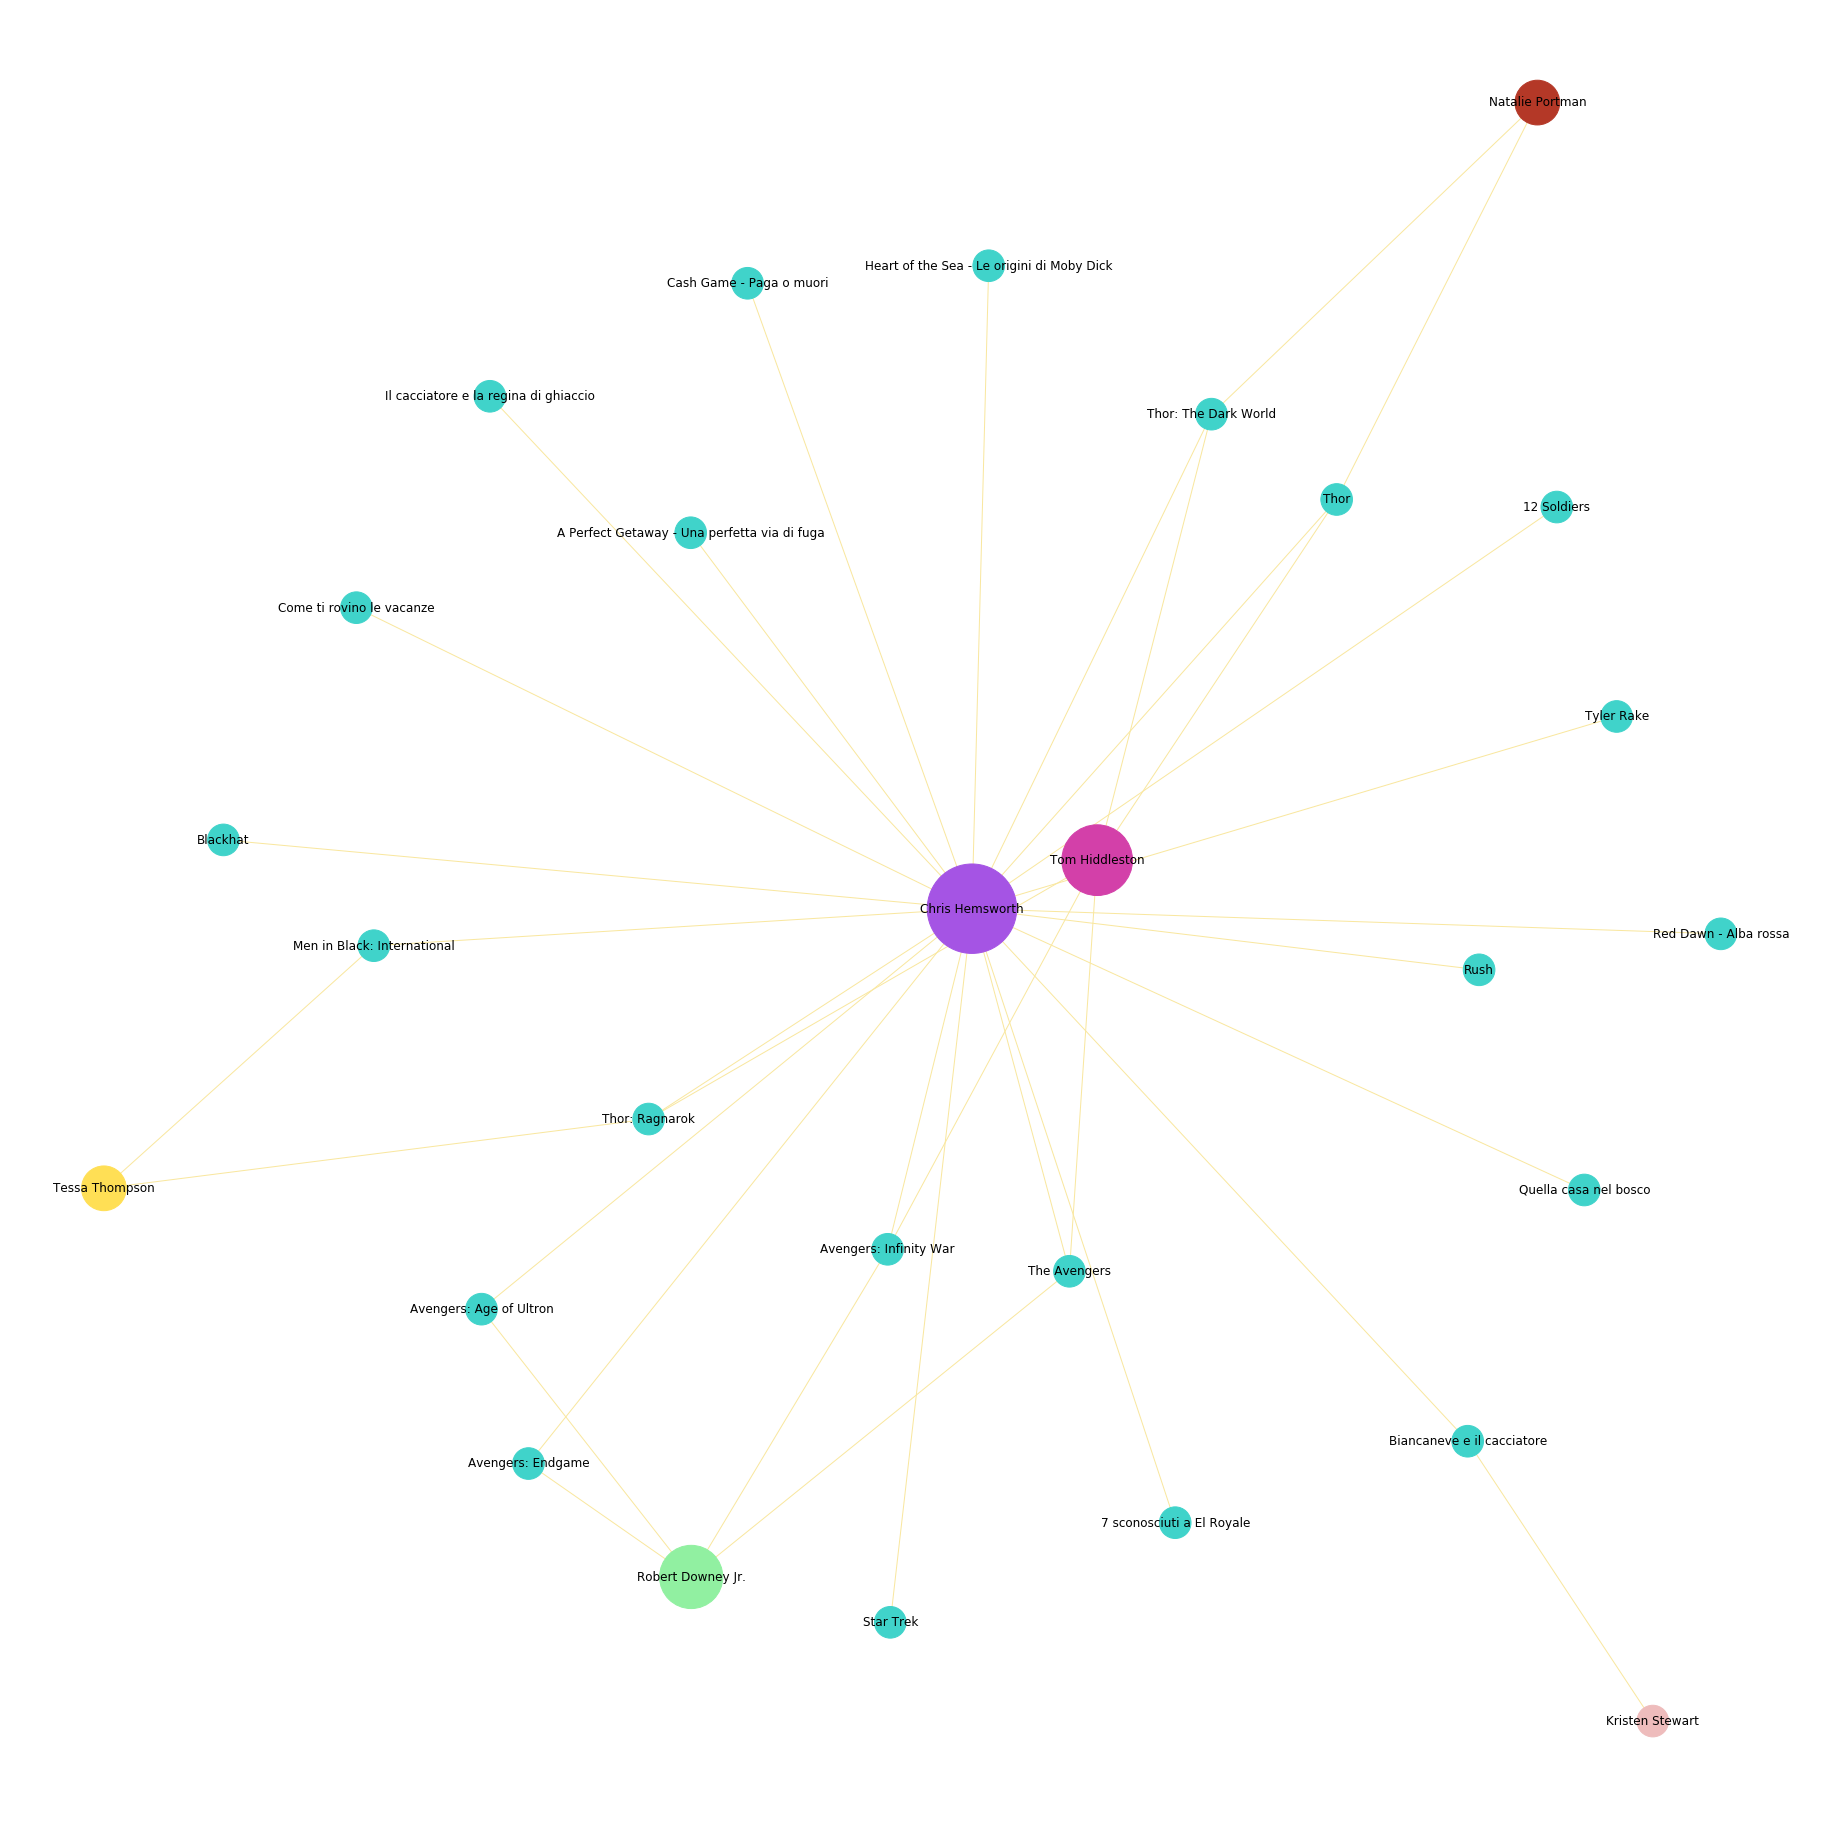

In [29]:
show_graph_actor_with_others(G_actor_with_others, num_natalie_portman, num_robert_downey_jr, num_tessa_thompson, num_kristen_stewart,num_tom_hiddleston)

In [30]:
degree_centrality_actor_with_others = nx.degree_centrality(G_actor_with_others)
sorted_degree_centrality_actor_with_others = sorted(degree_centrality_actor_with_others.items(),key=lambda x:x[1],reverse=True)
sorted_degree_centrality_actor_with_others

[('Chris Hemsworth', 0.8148148148148148),
 ('Tom Hiddleston', 0.18518518518518517),
 ('Robert Downey Jr.', 0.14814814814814814),
 ('Thor', 0.1111111111111111),
 ('The Avengers', 0.1111111111111111),
 ('Thor: The Dark World', 0.1111111111111111),
 ('Thor: Ragnarok', 0.1111111111111111),
 ('Avengers: Infinity War', 0.1111111111111111),
 ('Natalie Portman', 0.07407407407407407),
 ('Biancaneve e il cacciatore', 0.07407407407407407),
 ('Men in Black: International', 0.07407407407407407),
 ('Tessa Thompson', 0.07407407407407407),
 ('Avengers: Age of Ultron', 0.07407407407407407),
 ('Avengers: Endgame', 0.07407407407407407),
 ('Star Trek', 0.037037037037037035),
 ('A Perfect Getaway - Una perfetta via di fuga', 0.037037037037037035),
 ('Cash Game - Paga o muori', 0.037037037037037035),
 ('Red Dawn - Alba rossa', 0.037037037037037035),
 ('Quella casa nel bosco', 0.037037037037037035),
 ('Heart of the Sea - Le origini di Moby Dick', 0.037037037037037035),
 ('12 Soldiers', 0.037037037037037035),

In [31]:
betweenness_centrality_actor_with_others = nx.betweenness_centrality(G_actor_with_others)
sorted_betweenness_centrality_actor_with_others = sorted(betweenness_centrality_actor_with_others.items(),key=lambda x:x[1],reverse=True)
sorted_betweenness_centrality_actor_with_others

[('Chris Hemsworth', 0.9123321123321123),
 ('Biancaneve e il cacciatore', 0.07407407407407408),
 ('Thor: Ragnarok', 0.05057658390991725),
 ('Thor', 0.04601817935151267),
 ('Thor: The Dark World', 0.04601817935151267),
 ('Men in Black: International', 0.0315289648622982),
 ('The Avengers', 0.029405779405779393),
 ('Avengers: Infinity War', 0.029405779405779393),
 ('Tom Hiddleston', 0.026685660018993355),
 ('Avengers: Age of Ultron', 0.014577397910731241),
 ('Avengers: Endgame', 0.014577397910731241),
 ('Robert Downey Jr.', 0.009700176366843033),
 ('Tessa Thompson', 0.001899335232668566),
 ('Natalie Portman', 0.000949667616334283),
 ('Star Trek', 0.0),
 ('A Perfect Getaway - Una perfetta via di fuga', 0.0),
 ('Cash Game - Paga o muori', 0.0),
 ('Red Dawn - Alba rossa', 0.0),
 ('Quella casa nel bosco', 0.0),
 ('Heart of the Sea - Le origini di Moby Dick', 0.0),
 ('12 Soldiers', 0.0),
 ('Come ti rovino le vacanze', 0.0),
 ('Kristen Stewart', 0.0),
 ('Rush', 0.0),
 ('Il cacciatore e la regi

In [32]:
closeness_centrality_actor_with_others = nx.closeness_centrality(G_actor_with_others)
sorted_closeness_centrality_actor_with_others = sorted(closeness_centrality_actor_with_others.items(),key=lambda x:x[1],reverse=True)

sorted_closeness_centrality_actor_with_others

[('Chris Hemsworth', 0.84375),
 ('Thor', 0.5),
 ('The Avengers', 0.5),
 ('Thor: The Dark World', 0.5),
 ('Thor: Ragnarok', 0.5),
 ('Avengers: Infinity War', 0.5),
 ('Biancaneve e il cacciatore', 0.48214285714285715),
 ('Men in Black: International', 0.48214285714285715),
 ('Avengers: Age of Ultron', 0.48214285714285715),
 ('Avengers: Endgame', 0.48214285714285715),
 ('Star Trek', 0.46551724137931033),
 ('A Perfect Getaway - Una perfetta via di fuga', 0.46551724137931033),
 ('Cash Game - Paga o muori', 0.46551724137931033),
 ('Red Dawn - Alba rossa', 0.46551724137931033),
 ('Quella casa nel bosco', 0.46551724137931033),
 ('Heart of the Sea - Le origini di Moby Dick', 0.46551724137931033),
 ('12 Soldiers', 0.46551724137931033),
 ('Come ti rovino le vacanze', 0.46551724137931033),
 ('Rush', 0.46551724137931033),
 ('Il cacciatore e la regina di ghiaccio', 0.46551724137931033),
 ('Blackhat', 0.46551724137931033),
 ('7 sconosciuti a El Royale', 0.46551724137931033),
 ('Tyler Rake', 0.4655172

In [33]:
eigenvector_centrality_actor_with_others = nx.eigenvector_centrality(G_actor_with_others)
sorted_eigenvector_centrality_actor_with_others = sorted(eigenvector_centrality_actor_with_others.items(),key=lambda x:x[1],reverse=True)

sorted_eigenvector_centrality_actor_with_others

[('Chris Hemsworth', 0.6571041193271364),
 ('The Avengers', 0.19940834975084207),
 ('Avengers: Infinity War', 0.19940834975084207),
 ('Tom Hiddleston', 0.19134237845051924),
 ('Thor', 0.18529027371322188),
 ('Thor: The Dark World', 0.18529027371322188),
 ('Thor: Ragnarok', 0.1836057495381939),
 ('Avengers: Age of Ultron', 0.16099057733243816),
 ('Avengers: Endgame', 0.16099057733243816),
 ('Men in Black: International', 0.14518797711978992),
 ('Robert Downey Jr.', 0.1447206108323087),
 ('Biancaneve e il cacciatore', 0.1374754931282809),
 ('Star Trek', 0.13193353553179807),
 ('A Perfect Getaway - Una perfetta via di fuga', 0.13193353553179807),
 ('Cash Game - Paga o muori', 0.13193353553179807),
 ('Red Dawn - Alba rossa', 0.13193353553179807),
 ('Quella casa nel bosco', 0.13193353553179807),
 ('Heart of the Sea - Le origini di Moby Dick', 0.13193353553179807),
 ('12 Soldiers', 0.13193353553179807),
 ('Come ti rovino le vacanze', 0.13193353553179807),
 ('Rush', 0.13193353553179807),
 ('I

In [34]:
degree_actor_with_others = nx.degree(G_actor_with_others)
degree_actor_with_others = sorted(degree_director,key=lambda x:x[1],reverse=True)

degree_actor_with_others

[('Tim Burton', 23),
 ('Johnny Depp', 9),
 ('Helena Bonham Carter', 8),
 ('Michael Gough', 5),
 ('Danny DeVito', 4),
 ('La sposa cadavere', 4),
 ('Batman - Il ritorno', 3),
 ('Il mistero di Sleepy Hollow', 3),
 ('La fabbrica di cioccolato', 3),
 ('Sweeney Todd - Il diabolico barbiere di Fleet Street', 3),
 ('Alice in Wonderland', 3),
 ('Dark Shadows', 3),
 ('Batman', 2),
 ('Edward mani di forbice', 2),
 ('Ed Wood', 2),
 ('Mars Attacks!', 2),
 ('Planet of the Apes - Il pianeta delle scimmie', 2),
 ('Big Fish - Le storie di una vita incredibile', 2),
 ('Dumbo', 2),
 ("Pee-wee's Big Adventure", 1),
 ('Beetlejuice - Spiritello porcello', 1),
 ('Big Eyes', 1),
 ('Frankenweenie', 1),
 ('Miss Peregrine - La casa dei ragazzi speciali', 1)]

In [35]:
actor = "Meryl Streep"
num_drama = 0
num_comedy = 0
num_romance = 0
num_fantasy = 0
num_horror = 0
num_crime = 0
num_thriller = 0
num_music = 0
num_adventure = 0
G_actor_with_categories = nx.Graph()
for i, rowi in movies.iterrows():
    for element in rowi['list_actors']:
        if (element==actor):
            G_actor_with_categories.add_node(element,label="PERSON")
            for category in rowi['list_categories']:
                if category == "Drama":
                    num_drama = num_drama + 1
                    G_actor_with_categories.add_node(category,label="DRAMA")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
                elif category == "Comedy":
                    num_comedy = num_comedy + 1
                    G_actor_with_categories.add_node(category,label="COMEDY")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
                elif category == "Romance":
                    num_romance = num_romance + 1
                    G_actor_with_categories.add_node(category,label="ROMANCE")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
                elif category == "Fantasy":
                    num_fantasy = num_fantasy + 1
                    G_actor_with_categories.add_node(category,label="FANTASY")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
                elif category == "Horror":
                    num_horror = num_horror + 1
                    G_actor_with_categories.add_node(category,label="HORROR")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
                elif category == "Crime":
                    num_crime = num_crime + 1
                    G_actor_with_categories.add_node(category,label="CRIME")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")    
                elif category == "Thriller":
                    num_thriller = num_thriller + 1
                    G_actor_with_categories.add_node(category,label="THRILLER")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
                elif category == "Music":
                    num_music = num_music + 1
                    G_actor_with_categories.add_node(category,label="MUSIC")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN") 
                elif category == "Adventure":
                    num_adventure = num_adventure + 1
                    G_actor_with_categories.add_node(category,label="ADVENTURE")
                    G_actor_with_categories.add_edge(category, element, label="ACTED_IN")
print(num_drama)
print(num_comedy)
print(num_romance)
print(num_fantasy)
print(num_horror)
print(num_crime)
print(num_thriller)
print(num_music)
print(num_adventure)
            

44
21
16
2
1
5
3
3
5


In [36]:
def show_graph_actor_with_categories(G, num_drama, num_comedy, num_romance, num_fantasy, num_horror, num_crime, num_thriller, num_music, num_adventure):

    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#F9E79F',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }
    colors=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="DRAMA":
            colors.append('#B43827')
        elif G.nodes[e]['label']=="COMEDY":
            colors.append('#91f0a1')
        elif G.nodes[e]['label']=="ROMANCE":
            colors.append('#ffdf55')
        elif G.nodes[e]['label']=="FANTASY":
            colors.append('#eebcbc')
        elif G.nodes[e]['label']=="HORROR":
            colors.append('#D340A9')
        elif G.nodes[e]['label']=="CRIME":
            colors.append('#A554E4')
        elif G.nodes[e]['label']=="THRILLER":
            colors.append('#40D3CA')
        elif G.nodes[e]['label']=="MUSIC":
            colors.append('#C39BD3')
        elif G.nodes[e]['label']=="ADVENTURE":
            colors.append('#17A589')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('#A9CCE3')
    sizes=[]
    for e in G.nodes():
        if G.nodes[e]['label']=="DRAMA":
            size=num_drama*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="COMEDY":
            size=num_comedy*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="ROMANCE":
            size=num_romance*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="FANTASY":
            size=num_fantasy*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="HORROR":
            size=num_horror*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="CRIME":
            size=num_crime*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="THRILLER":
            size=num_thriller*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="MUSIC":
            size=num_music*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="ADVENTURE":
            size=num_adventure*1000
            sizes.append(size)
        elif G.nodes[e]['label']=="PERSON":
            sizes.append(8000)
        else:
            sizes.append(1000)
    print(sizes)
    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.80, iterations=50), **options)
    plt.show()

[8000, 44000, 21000, 16000, 5000, 2000, 1000, 5000, 3000, 3000]


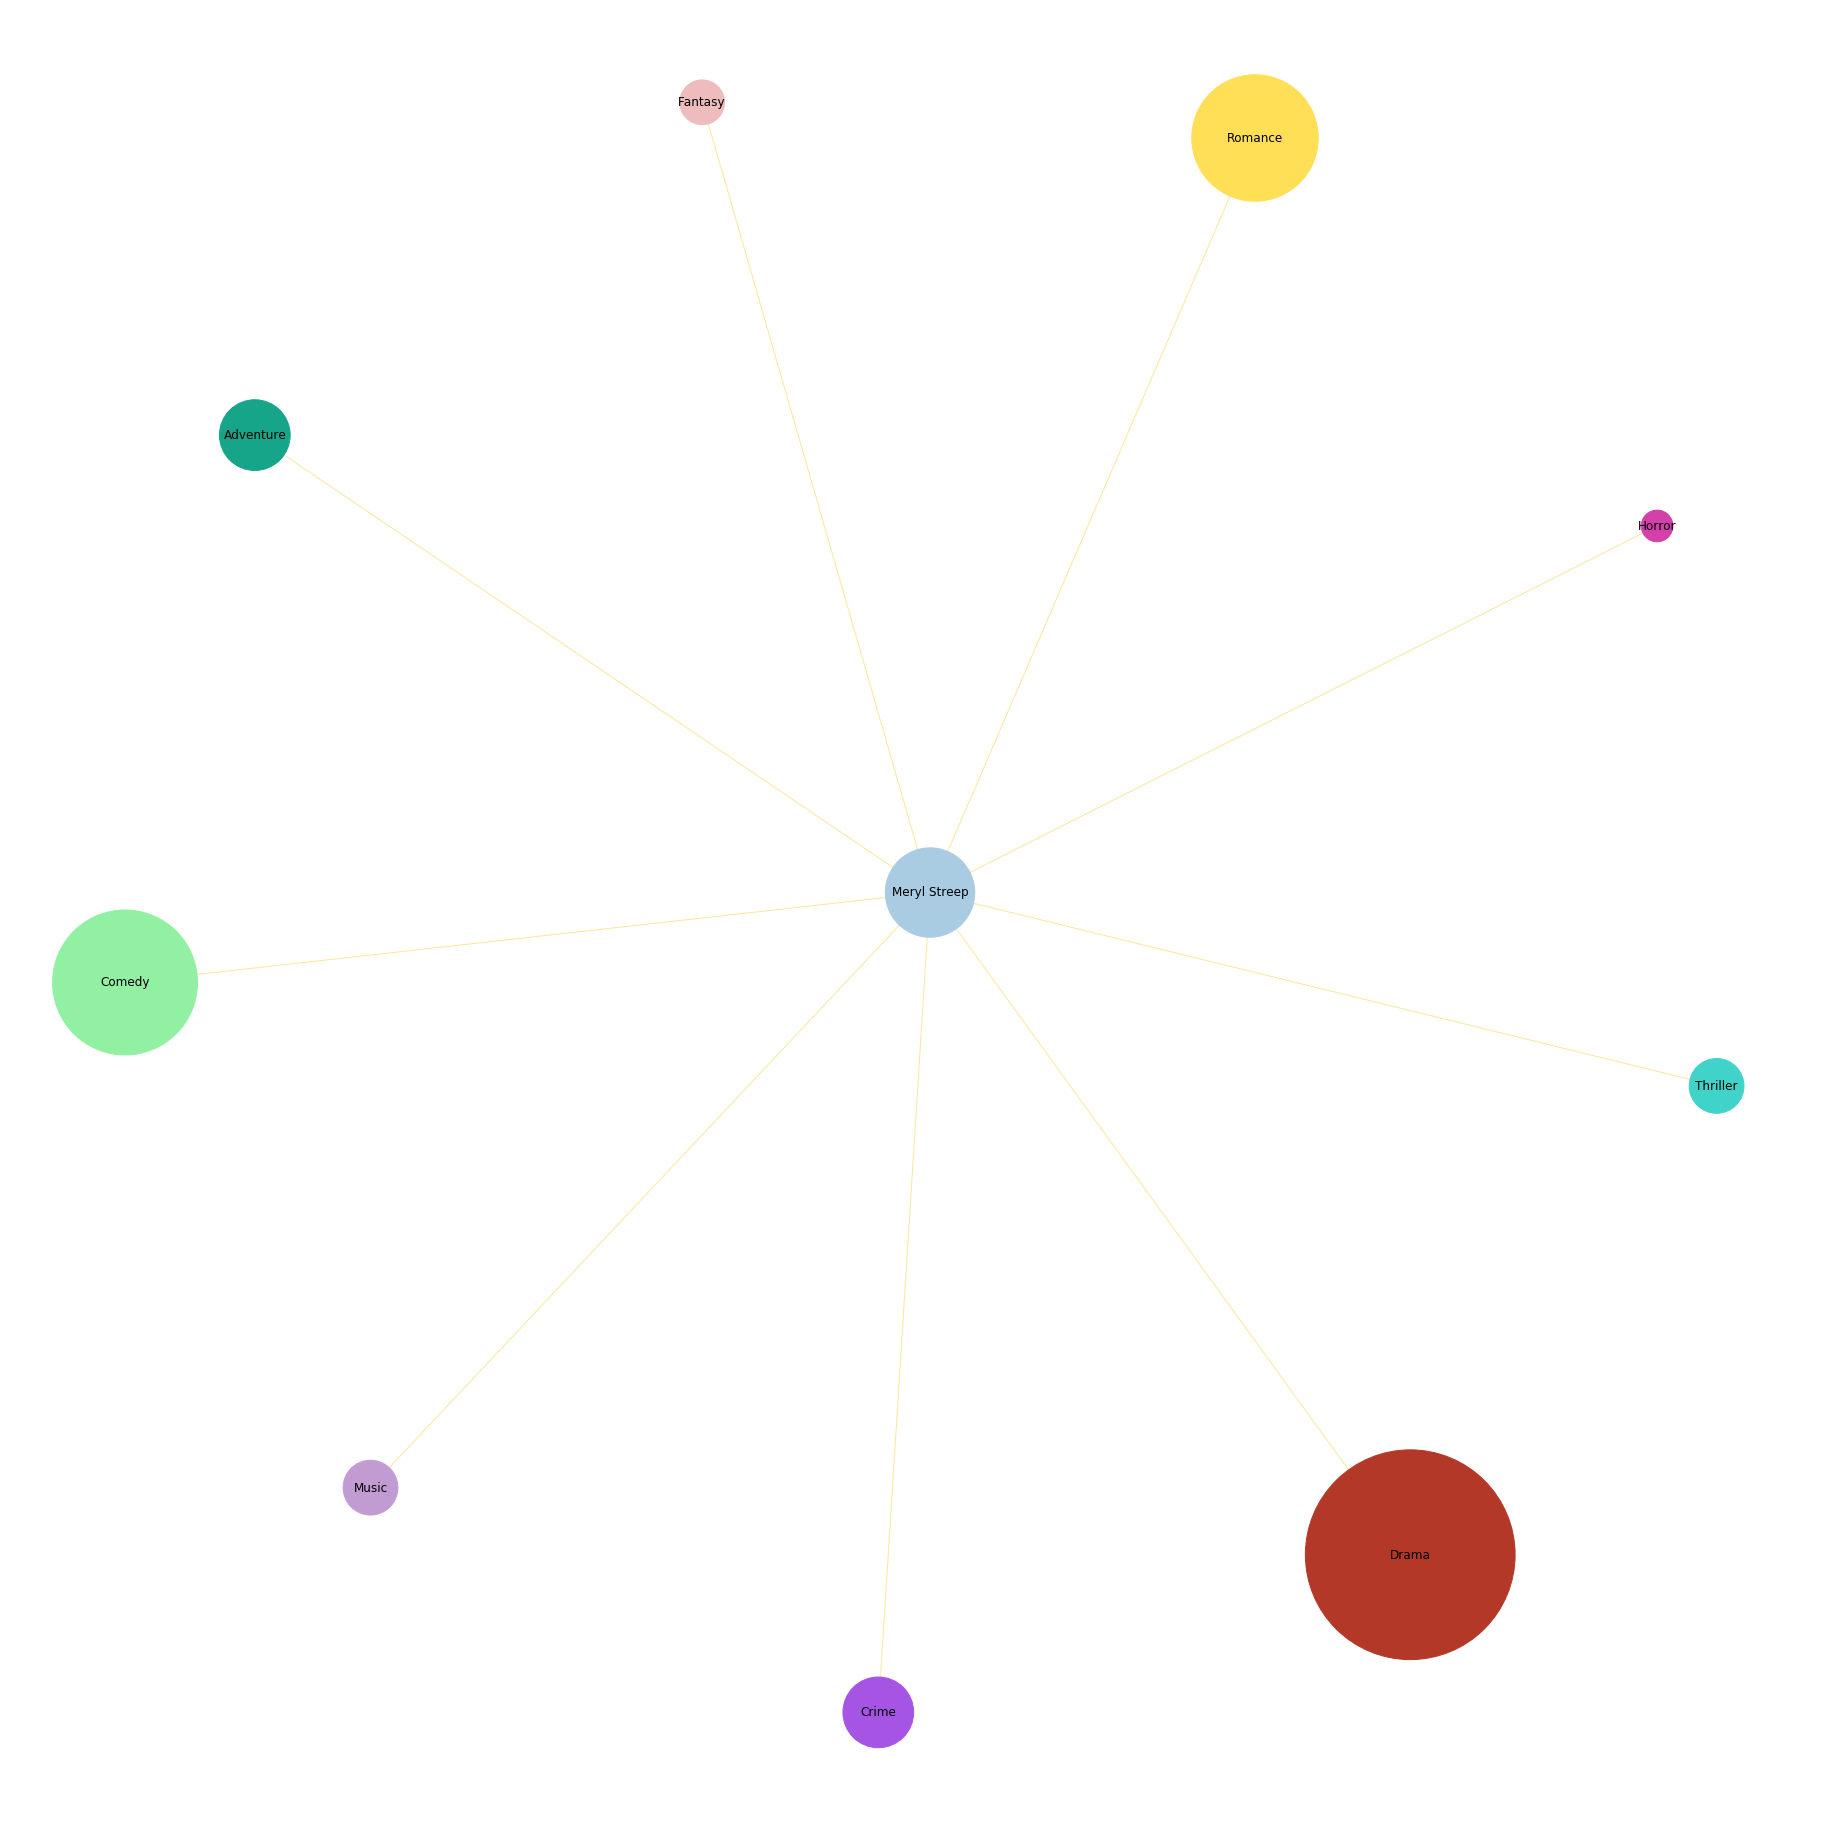

In [37]:
show_graph_actor_with_categories(G_actor_with_categories, num_drama, num_comedy, num_romance, num_fantasy, num_horror, num_crime, num_thriller, num_music, num_adventure)

In [38]:
ratings = pd.read_csv('../data/IMDb_ratings.csv')

In [39]:
ratings_movies = pd.merge(movies, ratings, on='imdb_title_id')
ratings_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85855 entries, 0 to 85854
Data columns (total 74 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              85855 non-null  object 
 1   title                      85855 non-null  object 
 2   original_title             85855 non-null  object 
 3   year                       85855 non-null  object 
 4   date_published             85855 non-null  object 
 5   genre                      85855 non-null  object 
 6   duration                   85855 non-null  int64  
 7   country                    85855 non-null  object 
 8   language                   85855 non-null  object 
 9   director                   85855 non-null  object 
 10  writer                     85855 non-null  object 
 11  production_company         85855 non-null  object 
 12  actors                     85855 non-null  object 
 13  description                85855 non-null  obj

In [40]:
ratings_movies['year'] = ratings_movies.year.astype('str')
ratings_movies['year'] = ratings_movies.year.str.strip()

In [41]:
ratings_movies['year'] = ratings_movies.year.drop(index = 83917, axis = 0)
ratings_movies = ratings_movies.dropna(subset=['year'], axis = 0)

In [42]:
ratings_movies[ratings_movies['year'].isnull()]

Empty DataFrame
Columns: [imdb_title_id, title, original_title, year, date_published, genre, duration, country, language, director, writer, production_company, actors, description, avg_vote, votes, budget, usa_gross_income, worlwide_gross_income, metascore, reviews_from_users, reviews_from_critics, list_directors, list_categories, list_actors, list_countries, weighted_average_vote, total_votes, mean_vote, median_vote, votes_10, votes_9, votes_8, votes_7, votes_6, votes_5, votes_4, votes_3, votes_2, votes_1, allgenders_0age_avg_vote, allgenders_0age_votes, allgenders_18age_avg_vote, allgenders_18age_votes, allgenders_30age_avg_vote, allgenders_30age_votes, allgenders_45age_avg_vote, allgenders_45age_votes, males_allages_avg_vote, males_allages_votes, males_0age_avg_vote, males_0age_votes, males_18age_avg_vote, males_18age_votes, males_30age_avg_vote, males_30age_votes, males_45age_avg_vote, males_45age_votes, females_allages_avg_vote, females_allages_votes, females_0age_avg_vote, females_0age_votes, females_18age_avg_vote, females_18age_votes, females_30age_avg_vote, females_30age_votes, females_45age_avg_vote, females_45age_votes, top1000_voters_rating, top1000_voters_votes, us_voters_rating, us_voters_votes, non_us_voters_rating, non_us_voters_votes]
Index: []

[0 rows x 74 columns]

In [43]:
ratings_movies['year'] = ratings_movies.year.astype('int')

In [44]:
genres_ratings = ratings_movies[['genre','title']].groupby(['genre']).count().reset_index().rename(columns={'title':'number_of_movies'})

genres_top10 = genres_ratings.sort_values(by='number_of_movies', ascending=False).iloc[:10]


In [45]:
genres_bar = px.bar(genres_top10, 
                    x = 'genre', 
                    y = 'number_of_movies', 
                    title = 'Top 10 Géneros en relación al número de películas',
                    text = 'number_of_movies', 
                    labels = dict(genre = 'Genre', number_of_movies = 'Number of movies'),
                    color = 'genre')
                    
genres_bar.show()